<a href="https://colab.research.google.com/github/LeonimerMelo/CNNs/blob/main/CNN_for_CIFAR_10_Photo_Classification_2_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Tutorial

## Convolutional Neural Networks - part #2

---

In this notebook, we load a pre-trained CNN to classify images from the CIFAR-10 database.

Carregando modelos já treinados previamente para previsões com o banco de dados de teste

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import classification_report
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from keras.utils import plot_model
from PIL import Image

In [ ]:
import os
from google.colab import drive
disk_check = os.path.ismount("/content/drive")
if(disk_check == False):
  drive.mount('/content/drive')
  disk_check = os.path.ismount("/content/drive")
  if(disk_check == False):
    print('Erro! Drive não pode ser montado!!')
else:
  print('Drive is already mounted!')

Mounted at /content/drive


In [ ]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# rescale [0,255] --> [0,1]
X_train, X_test = X_train / 255.0, X_test / 255.0
# one hot encoding
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## Functions

In [ ]:
# Função para plotar os gráficos da acurácia (accuracy) e da perda (loss)
def plot_acc_loss(h,model):
  plt.figure(figsize = (11,5))
  plt.subplot(1,2,1)
  plt.plot(h.history['loss'], label = 'Treino')
  plt.plot(h.history['val_loss'], label = 'Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Função Custo')
  plt.title('loss')
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.grid()
  plt.subplot(1,2,2)
  plt.plot(h.history['accuracy'], label = 'Treino')
  plt.plot(h.history['val_accuracy'], label = 'Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.title('accuracy')
  plt.xticks()
  plt.yticks()
  plt.legend()
  plt.tight_layout()
  plt.grid()
  plt.suptitle('model: '+str(model))
  plt.subplots_adjust(top=0.88)
  plt.show()

# função para visualização de uma forma elegante da matriz de confusão
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (13,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Função para carregar o modelo de rede treinado e o histórico de treinamento
def modelo_treinado(nr_modelo=1):
  nr_modelo=int(nr_modelo)
  if nr_modelo > 10 or nr_modelo < 1:
    print('Nr. do modelo inválido!')
    return

  disk_check = os.path.ismount("/content/drive")
  if(not disk_check):
    print('Erro!! O Drive não está montado!')
    return

  path_models = '/content/drive/MyDrive/Colab Notebooks/models/'
  # Load json and load model
  j_file = open(path_models + 'modelCNN_'+str(nr_modelo)+'.json','r')
  load_model_json = j_file.read()
  j_file.close()
  loaded_model=model_from_json(load_model_json)
  # Load weights into new model
  loaded_model.load_weights(path_models + 'weightsCNN_'+str(nr_modelo)+'.weights.h5')
  print('Loaded model '+str(nr_modelo)+' from disk')
  # carrego o 'history' que contem os vetores accuracy e loss para imprimir os gráficos novamente sem precisar treinar a rede
  history=np.load(path_models + 'history_'+str(nr_modelo)+'.npy',allow_pickle='TRUE').item()

  return loaded_model, history

# load pretrained model
def modelo(nr_modelo, x_test, y_test,
           summary=True, plot=True,
           m_confusion=True, report=True):

  nr_modelo=int(nr_modelo)
  if nr_modelo > 10 or nr_modelo < 1:
    print('Nr. do modelo inválido!')
    return 0,0

  disk_check = os.path.ismount("/content/drive")
  if(disk_check == False):
    drive.mount('/content/drive')
    disk_check = os.path.ismount("/content/drive")
    if(disk_check == False):
      print('Erro! Drive não pode ser montado!!')
      return 0,0
  # else:
    # print('Drive is already mounted!')

  model, hist = modelo_treinado(nr_modelo)
  if summary:
    print('\nModel Summary:')
    model.summary()

  if plot:
    plot_acc_loss(hist, model.name)

  print('\nTest dataset predictions:')
  prediction = model.predict(x_test)
  y_predict = np.argmax(prediction,axis=1)
  confusion = confusion_matrix(y_test, y_predict)

  if m_confusion:
    print('\nConfusion Matrix:')
    plot_confusion_matrix(confusion, classes = range(10))

  if report:
    print('\nClassification Report:')
    print(classification_report(y_test, y_predict))

  return model, y_predict

# load and prepare the image
def load_image(img_name):
  # drive path
  path='/content/drive/MyDrive/Colab Notebooks/images/'
  img_add = str(path) + str(img_name)
  # load the image
  img = load_img(img_add, target_size=(32, 32))
  # convert to array
  img = img_to_array(img)
  # reshape into a single sample with 3 channels
  img = img.reshape(1, 32, 32, 3)
  # prepare pixel data
  img = img.astype('float32')
  img = img / 255.0
  return img

cifar10_labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# image prediction
def predict_img(image, model):
  plt.figure(figsize=(4, 4))
  img = load_image(image)
  plt.imshow(img.reshape(32,32,3))
  plt.show()
  result = model.predict(img, verbose=0)
  y_pred=result.argmax()
  print('\nClass prediction:', y_pred)
  print('Prediction:', cifar10_labels[y_pred])
  print('Probalidade de acerto: %.2f%%' %(result.max()*100))

##Modelos treinados
Carregar o modelo de rede já treinado

Loaded model 9 from disk

Model Summary:


Model: "3_block_VGG_dropout_aug_norm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,104,598 (4.21 MB)

 Trainable params: 551,722 (2.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 551,724 (2.10 MB)

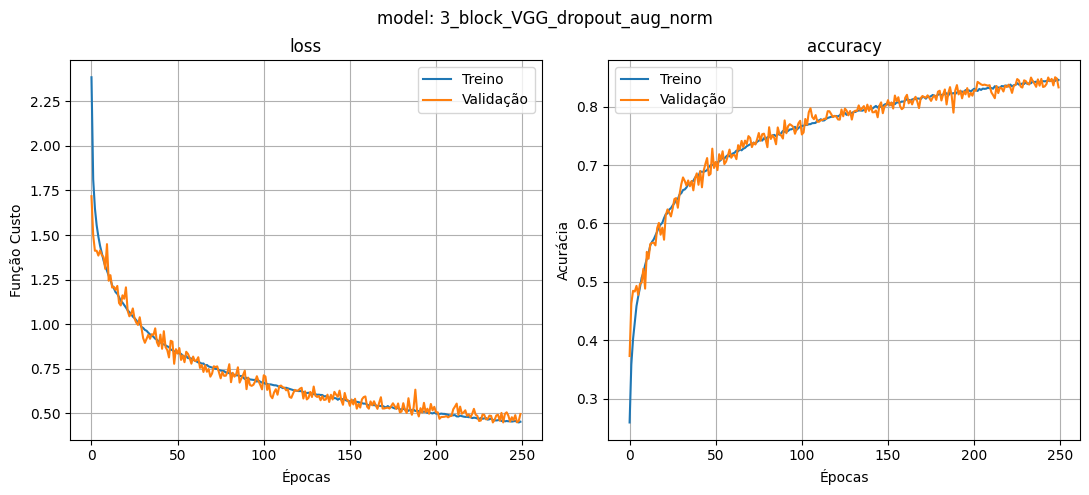


Test dataset predictions:
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 100ms/step

Confusion Matrix:


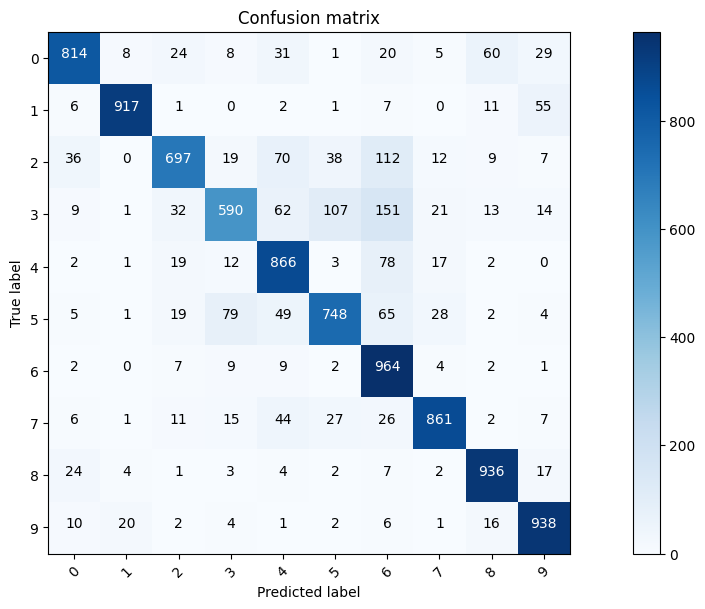


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1000
           1       0.96      0.92      0.94      1000
           2       0.86      0.70      0.77      1000
           3       0.80      0.59      0.68      1000
           4       0.76      0.87      0.81      1000
           5       0.80      0.75      0.77      1000
           6       0.67      0.96      0.79      1000
           7       0.91      0.86      0.88      1000
           8       0.89      0.94      0.91      1000
           9       0.88      0.94      0.91      1000

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000



In [ ]:
modelo_nr = 9
model, y_predict = modelo(modelo_nr, X_test, y_test, summary=True,
                          plot=True, m_confusion=True, report=True)

### Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

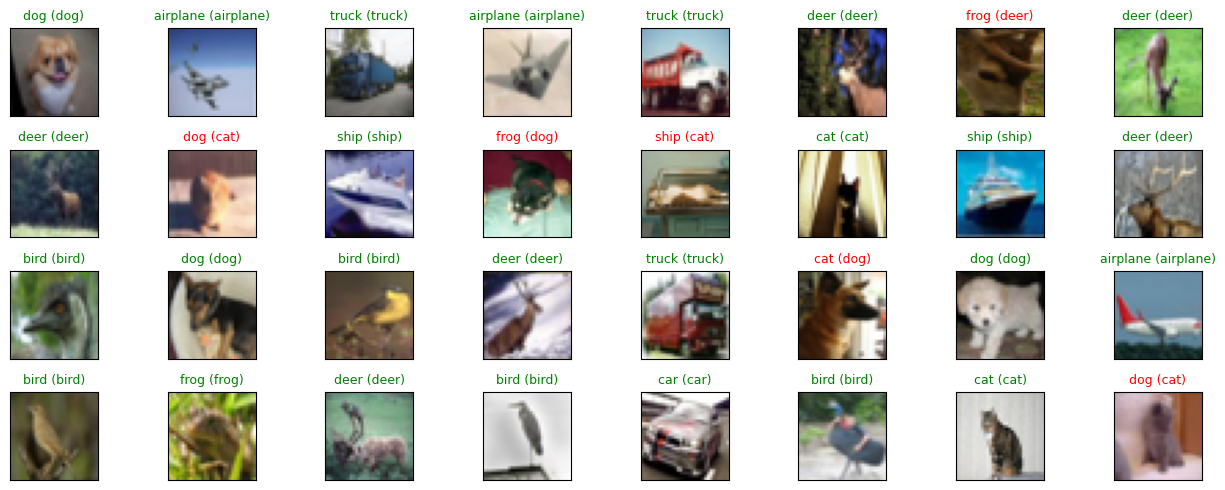

In [ ]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(13, 5))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=32, replace=False)):
  ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
  #ax.imshow(np.squeeze(X_test[idx]))
  ax.imshow(X_test[idx])
  pred_idx = y_predict[idx]
  true_idx = y_test[idx][0]
  # pred_idx = int(y_predict[idx])
  # true_idx = int(y_test[idx])
  ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
              color=("green" if pred_idx == true_idx else "red"), size=9)
plt.tight_layout()
plt.show()

##Make Prediction

We can use our saved model to make a prediction on new images.

The model assumes that new images are color, they have been segmented so that one image contains one centered object, and the size of the image is square with the size 32×32 pixels.

Path for load images:
`path='/content/drive/MyDrive/Colab Notebooks/images/'`



Imagem original


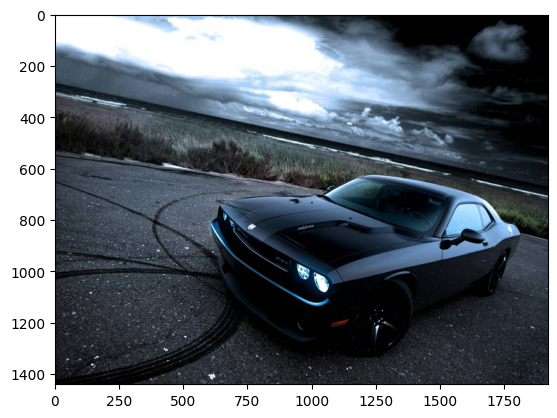


Imagem redimensionada 32x32 pixels


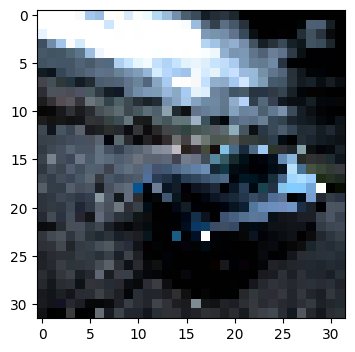


Class prediction: 1
Prediction: car
Probalidade de acerto: 60.86%


In [ ]:
# cifar10_labels = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
#img='deer.png'
img='car.jpg'
# img='dog5.jpg'
#img='dog_.jpg'
#img='barco1.jpg'
#img='barco2.png'
#img='vaca1.jpg'
# img='onix.png'
#img='horse.jpeg'
# img='sapo.jpeg'
#img='sapo2.jpeg'
#img='caminhao1.jpg'
#img='cat2.jpg'
#img='cat5.jpg'
#img='aviao1.png'
#img='deer2.jpg'
#img='passaro1.jpg'
print('Imagem original')
data  = Image.open('/content/drive/MyDrive/Colab Notebooks/images/'+img)
plt.imshow(data)
plt.show()
print('\nImagem redimensionada 32x32 pixels')
predict_img(img, model)

##Exercícios

1. Faça uma análise dos modelos pré-treinados utilizando as ferramentas de métricas disponíveis (matriz de confusão e Classification Report) e verifique qual modelo teve melhor desempenho.
1. Crie um gráfico e/ou tabela comparativa com os falsos positivos e falsos negativos das classes e verifique qual modelo foi melhor/pior na equalização dos acertos das classes.
1. Teste o novo modelo criado na parte #1 com a topologia completa da rede VGG16 e verifique seu desempenho em comparação aos demais.
1. Monte um banco de dados de imagens contendo pelo menos 10 amostras de cada classe, rode em cada um dos modelos pré-treinados e salve os resultados. Monte uma tabela comparativa e comente os resultados e acurácia obtidados.